In [1]:
import networkx as nx 
from matplotlib import pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
import networkx as nx
import random
import torch
import copy
import pandas as pd
import gc

from gsnn.models.GSNN import GSNN
from gsnn.models.NN import NN
from gsnn.simulate.nx2pyg import nx2pyg
from gsnn.simulate.simulate import simulate
from gsnn.reinforce.EarlyStopper import EarlyStopper

# for reproducibility 
torch.manual_seed(0)
np.random.seed(0)

/home/teddy/miniconda3/envs/gsnn/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Training and comparison to baselines on a simple task

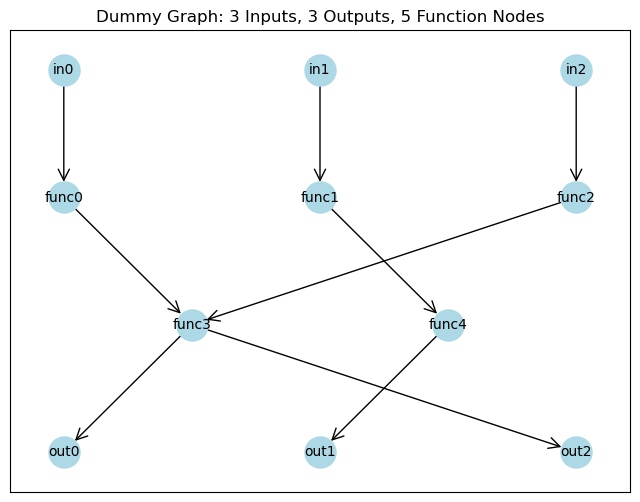

In [2]:
# Create a simple directed graph with 3 inputs, 3 outputs, and 5 function nodes
G = nx.DiGraph()

# Add input nodes, function nodes, and output nodes
input_nodes = ['in0', 'in1', 'in2']
function_nodes = ['func0', 'func1', 'func2', 'func3', 'func4']
output_nodes = ['out0', 'out1', 'out2']

# Add edges from input nodes to function nodes
G.add_edges_from([('in0', 'func0'), ('in1', 'func1'), ('in2', 'func2')])

# Add edges between function nodes
G.add_edges_from([('func0', 'func3'), ('func1', 'func4'), ('func2', 'func3')])

# Add edges from function nodes to output nodes
G.add_edges_from([('func3', 'out0'), ('func4', 'out1'), ('func3', 'out2')])

# Define positions for each node for plotting
pos = {
    'in0': (-2, 2), 'in1': (0, 2), 'in2': (2, 2),
    'func0': (-2, 1), 'func1': (0, 1), 'func2': (2, 1),
    'func3': (-1, 0), 'func4': (1, 0),
    'out0': (-2, -1), 'out1': (0, -1), 'out2': (2, -1)
}

# Plot the graph
plt.figure(figsize=(8, 6))
nx.draw_networkx(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, arrowstyle='->', arrowsize=20)
plt.title("Dummy Graph: 3 Inputs, 3 Outputs, 5 Function Nodes")
plt.show()

In [3]:
data = nx2pyg(G, input_nodes, function_nodes, output_nodes)

In [4]:
x_train, x_test, y_train, y_test = simulate(G, n_train=50, n_test=500, input_nodes=input_nodes, output_nodes=output_nodes, 
                                            special_functions={'func1': lambda x: -np.mean(x), 'func2':lambda x: np.sum([np.exp(xx) for xx in x]), 
                                                               'func0': lambda x: np.mean(([(xx-1)**2 for xx in x])), 'func3': lambda x: -np.mean(x) if all([xx > 0 for xx in x]) else np.mean(x)})

device = 'cuda' if torch.cuda.is_available() else 'cpu'

x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

y_mu = y_train.mean(0); y_std = y_train.std(0)

y_train = (y_train - y_mu)/(y_std + 1e-8)
y_test = (y_test - y_mu)/(y_std + 1e-8)

In [5]:
def train(model, model_params, train_params, x_train, y_train, x_test, y_test, device, max_epochs=500): 

    gc.collect() 
    torch.cuda.empty_cache()

    model = model(**model_params).to(device)

    optim = torch.optim.Adam(model.parameters(), lr=train_params['lr'])
    crit = torch.nn.MSELoss()

    early_stopper = EarlyStopper(patience=10, min_delta=1e-3)

    losses = []
    for i in range(max_epochs): 
        model.train()
        optim.zero_grad() 
        yhat = model(x_train)
        loss = crit(y_train, yhat)
        loss.backward() 
        optim.step()

        with torch.no_grad(): 
            model.eval()
            loss = crit(model(x_test), y_test)
            losses.append(loss.item())
            if early_stopper.early_stop(loss): break

    del model; del optim; del crit 

    return losses

def run_search(model, model_params, training_params, x_train, y_train, x_test, y_test, device, iters=10):

    res = {**{k:[] for k in model_params.keys() if k not in ['edge_index_dict', 'node_names_dict']}, **{k:[] for k in training_params.keys()}}
    losses = []
    for i in range(iters): 
        print(f'progress: {i}/{iters}', end='\r')
        
        mp = {k:np.random.choice(model_params[k], size=1).item() for k,v in model_params.items()}
        tp = {k:np.random.choice(training_params[k], size=1).item() for k,v in training_params.items()}
        losses.append( train(model, mp, tp, x_train, y_train, x_test, y_test, device) )

        _=[res[k].append(v) for k,v in mp.items() if k not in ['edge_index_dict', 'node_names_dict']] 
        _=[res[k].append(v) for k,v in tp.items()]

    res = pd.DataFrame(res)
    return res, losses

In [6]:
iters = 50

In [7]:
model_params = {'edge_index_dict':[data.edge_index_dict], 
                'node_names_dict':[data.node_names_dict], 
                'channels':[2,5,10,20], 
                'layers':[3,5,10],
                'share_layers':[True, False], 
                'add_function_self_edges':[True, False],
                'norm':['none', 'layer'],
                'bias':[True, False], 
                'residual':[True, False],
                'dropout':[0, 0.1, 0.25]}

training_params = {'lr': [1e-2, 1e-3]} 

res_gsnn, losses_gsnn = run_search(GSNN, model_params, training_params, x_train, y_train, x_test, y_test, device, iters=iters)

In [8]:
edge_index_dict = copy.deepcopy(data.edge_index_dict)
E = edge_index_dict['function', 'to', 'function'].size(1)
edge_index_dict['function', 'to', 'function']  = torch.randint(low=0, high=len(function_nodes), size=(2,E))

model_params = {'edge_index_dict':[edge_index_dict], 
                'node_names_dict':[data.node_names_dict], 
                'channels':[2,5,10,20], 
                'layers':[3,5,10],
                'share_layers':[True, False], 
                'add_function_self_edges':[True, False],
                'norm':['none', 'layer'],
                'bias':[True, False], 
                'residual':[True, False],
                'dropout':[0, 0.1, 0.25]}

training_params = {'lr': [1e-2, 1e-3]} 

res_gsnn2, losses_gsnn2 = run_search(GSNN, model_params, training_params, x_train, y_train, x_test, y_test, device, iters=iters)

In [9]:
edge_index_dict = copy.deepcopy(data.edge_index_dict)
edge_index_dict['function', 'to', 'function']  = torch.stack((torch.arange(len(function_nodes)).repeat_interleave(len(function_nodes)), 
                                                              torch.arange(len(function_nodes)).repeat(len(function_nodes))), dim=0)

model_params = {'edge_index_dict':[edge_index_dict], 
                'node_names_dict':[data.node_names_dict], 
                'channels':[2,5,10,20], 
                'layers':[3,5,10],
                'share_layers':[True, False], 
                'add_function_self_edges':[True, False],
                'norm':['none', 'layer'],
                'bias':[True, False], 
                'residual':[True, False],
                'dropout':[0, 0.1, 0.25]}

training_params = {'lr': [1e-2, 1e-3]} 

res_gsnn3, losses_gsnn3 = run_search(GSNN, model_params, training_params, x_train, y_train, x_test, y_test, device, iters=iters)

In [10]:
model_params = {'in_channels':[x_train.size(1)], 
                'out_channels':[y_train.size(1)], 
                'hidden_channels':[10,20,40,80,120], 
                'layers':[1,2],
                'norm':[torch.nn.BatchNorm1d, None],
                'dropout':[0, 0.1, 0.25]}

training_params = {'lr': [1e-2, 1e-3]} 

res_nn, losses_nn = run_search(NN, model_params, training_params, x_train, y_train, x_test, y_test, device, iters=iters)

In [11]:
print(f'best test loss NN: {min([min(loss) for loss in losses_nn])}')
print(f'best test loss GSNN: {min([min(loss) for loss in losses_gsnn])}')
print(f'best test loss GSNN (rand graph): {min([min(loss) for loss in losses_gsnn2])}')
print(f'best test loss GSNN (fully connected): {min([min(loss) for loss in losses_gsnn3])}')

best test loss NN: 1.0502902269363403
best test loss GSNN: 1.0157009363174438
best test loss GSNN (rand graph): 1.160701036453247
best test loss GSNN (fully connected): 1.0572221279144287


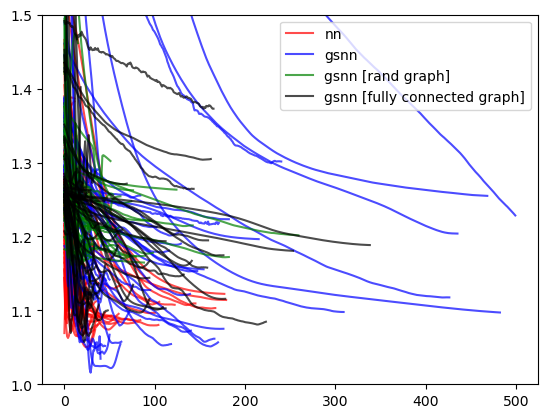

In [15]:
alpha = 0.7

plt.figure()

for i, loss in enumerate(losses_nn): 
    if i == 0: 
        plt.plot(loss, 'r-', label='nn', alpha=alpha)
    else:
        plt.plot(loss, 'r-', alpha=alpha)

for i, loss in enumerate(losses_gsnn): 
    if i == 0: 
        plt.plot(loss, 'b-', label='gsnn', alpha=alpha)
    else:
        plt.plot(loss, 'b-', alpha=alpha)

for i, loss in enumerate(losses_gsnn2): 
    if i == 0: 
        plt.plot(loss, 'g-', label='gsnn [rand graph]', alpha=alpha)
    else:
        plt.plot(loss, 'g-', alpha=alpha)

for i, loss in enumerate(losses_gsnn3): 
    if i == 0: 
        plt.plot(loss, 'k-', label='gsnn [fully connected graph]', alpha=alpha)
    else:
        plt.plot(loss, 'k-', alpha=alpha)

plt.ylim(1.,1.5)
plt.legend()
#plt.yscale('log')
plt.show()

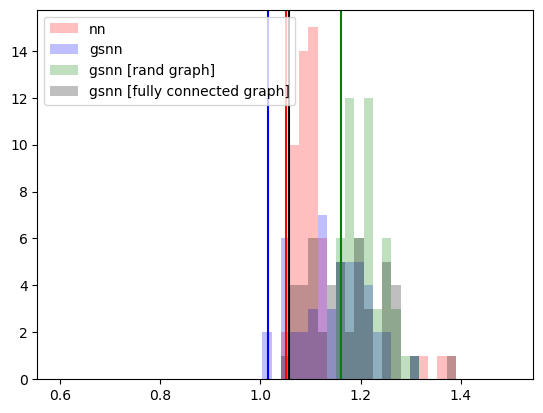

In [16]:
bins = np.linspace(0.6,1.5,50)

plt.figure()
plt.hist([min(loss) for loss in losses_nn], label='nn', alpha=0.25, color='r', bins=bins)
plt.hist([min(loss) for loss in losses_gsnn], label='gsnn', alpha=0.25, color='b', bins=bins)
plt.hist([min(loss) for loss in losses_gsnn2], label='gsnn [rand graph]', alpha=0.25, color='g', bins=bins)
plt.hist([min(loss) for loss in losses_gsnn3], label='gsnn [fully connected graph]', alpha=0.25, color='k', bins=bins)

plt.axvline(np.min([min(loss) for loss in losses_nn]),  color='r')
plt.axvline(np.min([min(loss) for loss in losses_gsnn]),  color='b')
plt.axvline(np.min([min(loss) for loss in losses_gsnn2]),  color='g')
plt.axvline(np.min([min(loss) for loss in losses_gsnn3]), color='k')

plt.legend()
plt.show()

In [17]:
# best gsnn hyper params 
res_gsnn = res_gsnn.assign(best_test = [min(loss) for loss in losses_gsnn])
res_gsnn.sort_values(by='best_test', ascending=True).head(10)

,channels,layers,share_layers,add_function_self_edges,norm,bias,residual,dropout,lr,best_test
12,20,10,True,True,none,False,True,0.00,0.010,1.015701
25,5,10,False,False,none,True,True,0.00,0.010,1.021921
30,20,3,True,True,none,True,True,0.10,0.010,1.041073
47,5,5,False,True,none,True,True,0.10,0.010,1.049045
7,20,5,False,True,none,True,True,0.25,0.001,1.051215
11,20,5,False,True,none,False,True,0.10,0.001,1.052541
0,2,5,False,False,none,True,True,0.00,0.010,1.055863
48,20,3,False,True,none,True,False,0.10,0.001,1.057543
5,20,5,False,True,none,True,False,0.25,0.001,1.071009
42,20,3,False,False,none,True,True,0.00,0.001,1.074982
